**Task 4**

**Question 1** 

Pick an image of your liking and reconstruct it using matrix factorization. Choose a suitable value for the rank 
r
. Run Gradient Descent until it converges, plot the reconstructed image alongside the original image. Calculate and report the RMSE and PSNR metrics. 

Image exists
Original Image Shape: torch.Size([3, 1365, 2048])


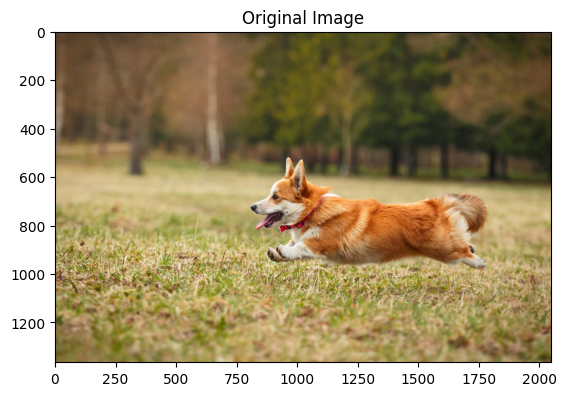

Number of masked pixels: 837822


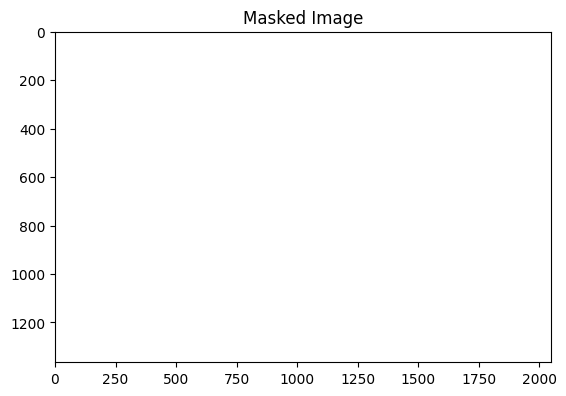

Factorizing channel 1
Epoch 0: Loss = 19808.0859375
Epoch 100: Loss = 1917.1053466796875
Epoch 200: Loss = 87.52084350585938
Epoch 300: Loss = 72.72470092773438
Epoch 400: Loss = 67.86734008789062
Epoch 500: Loss = 64.80949401855469
Epoch 600: Loss = 62.20258331298828
Epoch 700: Loss = 60.12773895263672
Epoch 800: Loss = 58.32283401489258
Epoch 900: Loss = 57.00425720214844
Epoch 1000: Loss = 55.655128479003906
Epoch 1100: Loss = 54.457820892333984
Epoch 1200: Loss = 53.27349090576172
Epoch 1300: Loss = 52.01030349731445
Epoch 1400: Loss = 51.08440017700195
Epoch 1500: Loss = 50.13806915283203
Epoch 1600: Loss = 49.27293014526367
Epoch 1700: Loss = 48.23343276977539
Epoch 1800: Loss = 47.42539596557617
Epoch 1900: Loss = 46.80189895629883
Epoch 2000: Loss = 46.060787200927734
Epoch 2100: Loss = 45.440673828125
Epoch 2200: Loss = 44.75615310668945
Epoch 2300: Loss = 44.269500732421875
Epoch 2400: Loss = 43.71089172363281
Epoch 2500: Loss = 43.24089813232422
Epoch 2600: Loss = 42.7439002

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.16646558..1.0965605].


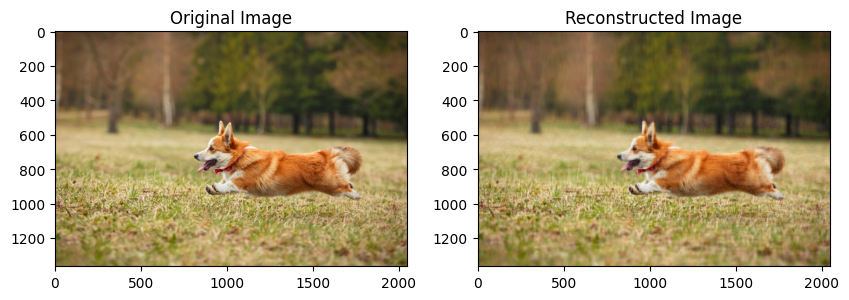

RMSE: 0.032860055565834045
PSNR: 29.666636812457895


In [7]:
import os
import torch
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio as psnr

# Check if the image path exists
image_path = 'dog.jpg'  # Fixed path
if os.path.exists(image_path):
    print("Image exists")
else:
    print("Image does not exist")

# Load the image and retain RGB channels
img = torchvision.io.read_image(image_path).float() / 255.0  # Normalize to [0, 1] range
print(f"Original Image Shape: {img.shape}")  # Shape will be [C, H, W] for colored images

# Display the original image
plt.imshow(img.permute(1, 2, 0))  # Convert to [H, W, C] for display
plt.title("Original Image")
plt.show()

def factorize_channel(channel_data, k, device=torch.device("cpu"), epochs=3000):
    """Factorize a single channel of the image matrix to reconstruct the missing pixels."""
    channel_data = channel_data.to(device)
    
    # Randomly initialize W and H
    W = torch.randn(channel_data.shape[0], k, requires_grad=True, device=device)
    H = torch.randn(k, channel_data.shape[1], requires_grad=True, device=device)
    
    # Optimizer
    optimizer = optim.Adam([W, H], lr=0.01)
    
    # Mask to identify non-NaN elements
    mask = ~torch.isnan(channel_data)
    
    # Train the model
    for epoch in range(epochs):
        # Compute the loss
        diff_matrix = torch.mm(W, H) - channel_data
        diff_vector = diff_matrix[mask]
        loss = torch.norm(diff_vector)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Backpropagate
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
        # Optional: Print loss every 100 epochs
        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item()}")

    return W, H, loss

def mask_image(img, prop):
    """Mask a proportion of the image across all channels."""
    img_copy = img.clone()
    mask = torch.rand(img_copy.shape[1], img_copy.shape[2]) < prop  # Create a mask for HxW
    # Apply the mask to all channels
    for c in range(img_copy.shape[0]):
        img_copy[c][mask] = float('nan')
    return img_copy, mask

def calculate_rmse(original, reconstructed):
    """Calculate RMSE between original and reconstructed images"""
    # Flatten the images and calculate MSE
    mse = mean_squared_error(original.flatten(), reconstructed.flatten())
    # Return the square root of MSE (RMSE)
    return torch.sqrt(torch.tensor(mse))

# Mask the image
masked_img, mask = mask_image(img, 0.3)
print(f"Number of masked pixels: {mask.sum()}")

# Display the masked image
plt.imshow(masked_img.permute(1, 2, 0))
plt.title("Masked Image")
plt.show()

# Set device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Factorize and reconstruct each channel independently
k = 200  # Number of latent features
reconstructed_img = torch.zeros_like(masked_img)

for c in range(img.shape[0]):
    print(f"Factorizing channel {c+1}")
    W, H, loss = factorize_channel(masked_img[c], k, device=device)
    reconstructed_img[c] = torch.mm(W, H).cpu().detach()

# Convert the original and reconstructed images to NumPy arrays for PSNR calculation
original_img_np = img.cpu().numpy()
reconstructed_img_np = reconstructed_img.cpu().numpy()

# Calculate RMSE
rmse = calculate_rmse(original_img_np, reconstructed_img_np)

# Calculate PSNR, specifying the data_range to be 1 since we normalized the image to [0, 1]
psnr_value = psnr(original_img_np, reconstructed_img_np, data_range=1.0)

# Plot original and reconstructed images side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(original_img_np.transpose(1, 2, 0))  # Convert to [H, W, C] for display
ax[0].set_title("Original Image")

ax[1].imshow(reconstructed_img_np.transpose(1, 2, 0))  # Convert to [H, W, C] for display
ax[1].set_title("Reconstructed Image")

plt.show()

# Print RMSE and PSNR
print(f"RMSE: {rmse}")
print(f"PSNR: {psnr_value}")


**QUESTION 2**

Consider a case where 900 pixels (30x30) are randomly missing from an image. Reconstruct the image using matrix factorization, plot the reconstructed image, and calculate the RMSE and PSNR metrics. Next, reconstruct the same image with the missing pixels using Random Fourier Features (RFF) and Linear Regression. Compute the RMSE and PSNR for both methods, and compare the results to see which performs better.

Reconstructing channel 1/3
Iteration 0/3000, Loss: 4218.02197265625
Iteration 100/3000, Loss: 56.33164978027344
Iteration 200/3000, Loss: 11.565686225891113
Iteration 300/3000, Loss: 9.410136222839355
Iteration 400/3000, Loss: 8.60555362701416
Iteration 500/3000, Loss: 8.161116600036621
Iteration 600/3000, Loss: 7.793214797973633
Iteration 700/3000, Loss: 7.560502529144287
Iteration 800/3000, Loss: 7.367341995239258
Iteration 900/3000, Loss: 7.144650459289551
Iteration 1000/3000, Loss: 6.961066246032715
Iteration 1100/3000, Loss: 6.807839393615723
Iteration 1200/3000, Loss: 6.691457748413086
Iteration 1300/3000, Loss: 6.589564323425293
Iteration 1400/3000, Loss: 6.468574047088623
Iteration 1500/3000, Loss: 6.376373767852783
Iteration 1600/3000, Loss: 6.26450252532959
Iteration 1700/3000, Loss: 6.199572563171387
Iteration 1800/3000, Loss: 6.096756458282471
Iteration 1900/3000, Loss: 6.039182662963867
Iteration 2000/3000, Loss: 5.963636875152588
Iteration 2100/3000, Loss: 5.9009060859680

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07383791357278824..1.1206187009811401].


Training linear regression for channel 1/3
Training linear regression for channel 2/3
Training linear regression for channel 3/3
Linear Regression with RFF - RMSE: 0.21223447102517248
Linear Regression with RFF - PSNR: 13.46368153591363 dB


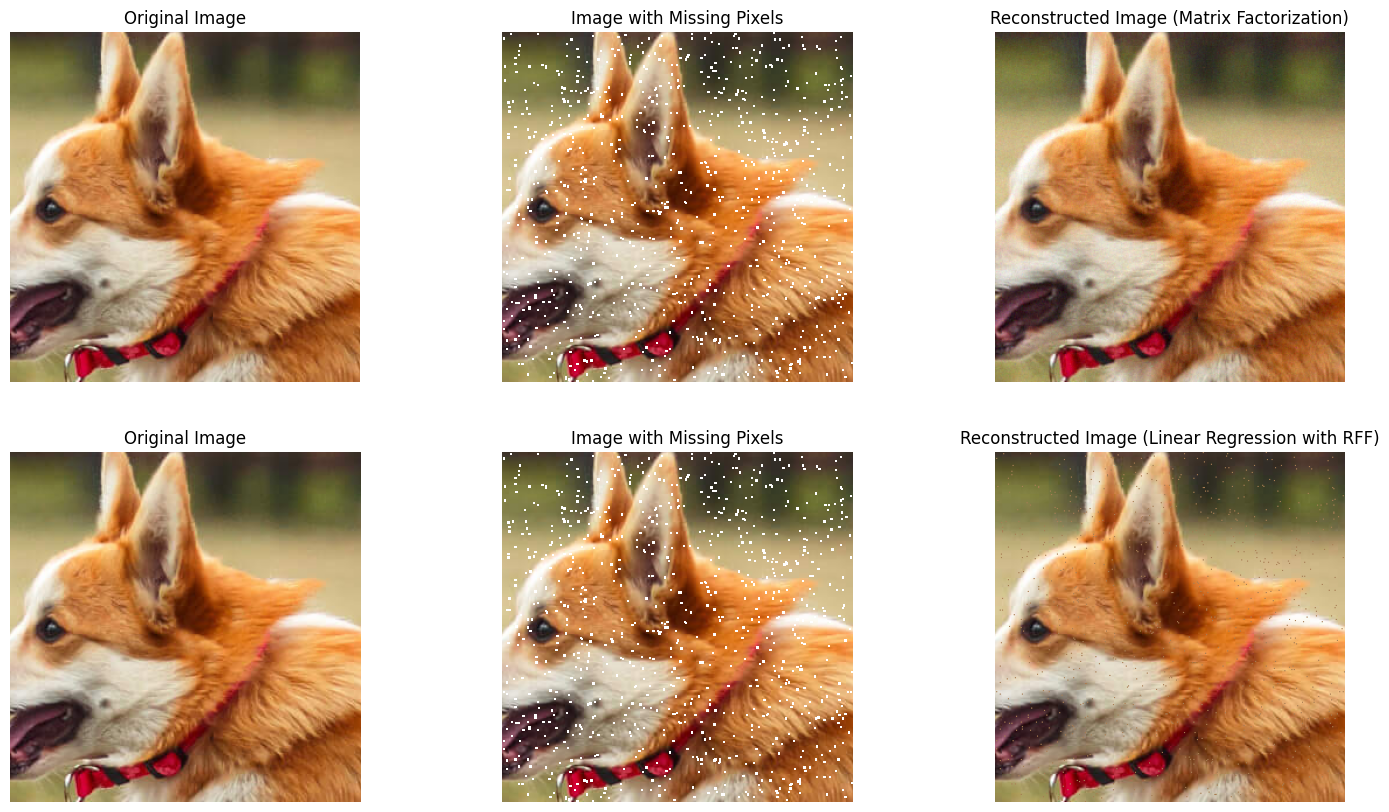

In [22]:
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torchvision
from sklearn.linear_model import LinearRegression

def remove_pixels(image, num_pixels):
    """Remove a specific number of pixels from the image."""
    image_with_missing = image.copy()
    flat_image = image_with_missing.reshape(-1, image_with_missing.shape[2])
    indices = np.random.choice(flat_image.shape[0], num_pixels, replace=False)
    for channel in range(image_with_missing.shape[2]):
        flat_image[indices, channel] = np.nan
    return flat_image.reshape(image_with_missing.shape), indices

def factorize_channel(channel_data, k, device=torch.device("cpu"), num_iterations=1000):
    """Factorize a single channel of the image matrix to reconstruct the missing pixels."""
    channel_data = torch.tensor(channel_data, dtype=torch.float).to(device)
    W = torch.randn(channel_data.shape[0], k, requires_grad=True, device=device)
    H = torch.randn(k, channel_data.shape[1], requires_grad=True, device=device)
    optimizer = optim.Adam([W, H], lr=0.01)
    mask = ~torch.isnan(channel_data)

    for i in range(num_iterations):
        diff_matrix = torch.mm(W, H) - channel_data
        diff_vector = diff_matrix[mask]
        loss = torch.norm(diff_vector)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print(f"Iteration {i}/{num_iterations}, Loss: {loss.item()}")

    return torch.mm(W, H).cpu().detach().numpy()

def factorize_image(image, k, device=torch.device("cpu"), num_iterations=3000):
    """Factorize the image matrix (all channels) to reconstruct the missing pixels."""
    reconstructed_image = np.zeros_like(image)
    for channel in range(image.shape[2]):
        print(f"Reconstructing channel {channel + 1}/{image.shape[2]}")
        reconstructed_image[:, :, channel] = factorize_channel(image[:, :, channel], k, device, num_iterations)
    return reconstructed_image

def calculate_rmse(original, reconstructed, missing_indices):
    """Calculate RMSE between original and reconstructed images only at missing indices."""
    original_flat = original.reshape(-1, original.shape[2])
    reconstructed_flat = reconstructed.reshape(-1, reconstructed.shape[2])
    mse = np.nanmean((original_flat[missing_indices] - reconstructed_flat[missing_indices]) ** 2)
    rmse = np.sqrt(mse)
    return rmse

def calculate_psnr(original, rmse):
    """Calculate PSNR based on the RMSE."""
    max_pixel = 1.0  # Assuming the image is normalized to the range [0, 1]
    psnr = 20 * np.log10(max_pixel / rmse)
    return psnr

def generate_random_features(image, num_features):
    """Generate random features for each pixel."""
    height, width, channels = image.shape
    num_pixels = height * width
    features = np.random.rand(num_pixels, num_features)
    return features

def train_linear_regression(features, image, missing_indices):
    """Train linear regression models for each channel separately."""
    height, width, channels = image.shape
    num_pixels = height * width
    flat_image = image.reshape(-1, channels)
    known_indices = np.setdiff1d(np.arange(num_pixels), missing_indices)
    X_train = features[known_indices]
    reconstructed_flat_image = np.zeros_like(flat_image)

    for channel in range(channels):
        print(f"Training linear regression for channel {channel + 1}/{channels}")
        y_train = flat_image[known_indices, channel]
        model = LinearRegression()
        model.fit(X_train, y_train)
        X_missing = features[missing_indices]
        reconstructed_flat_image[missing_indices, channel] = model.predict(X_missing)
        reconstructed_flat_image[known_indices, channel] = flat_image[known_indices, channel]

    return reconstructed_flat_image.reshape(height, width, channels)

def random_fourier_features(features, num_features, sigma=1.0):
    """Generate Random Fourier Features."""
    num_samples = features.shape[0]
    weights = np.random.normal(0, 1/sigma, (features.shape[1], num_features))
    phase_shifts = np.random.uniform(0, 2 * np.pi, num_features)
    rff = np.sqrt(2.0 / num_features) * np.cos(features @ weights + phase_shifts)
    return rff

# Download the image if it doesn't exist
if not os.path.exists('dog.jpg'):
    url = 'https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg'
    response = requests.get(url)
    if response.status_code == 200:
        with open('dog.jpg', 'wb') as file:
            file.write(response.content)
        print('dog.jpg downloaded successfully')
    else:
        print('Failed to download the image')

# Load and convert the image to a NumPy array
image_tensor = torchvision.io.read_image('dog.jpg')
image = image_tensor.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)

# Ensure the image is normalized to the range [0, 1] if it's in uint8 format
if image.dtype == np.uint8:
    image = image / 255.0

# Crop the image to 300x300 pixels
crop_size = 300
height, width, _ = image.shape
if height >= crop_size and width >= crop_size:
    start_y = (height - crop_size) // 2
    start_x = (width - crop_size) // 2
    image = image[start_y:start_y + crop_size, start_x:start_x + crop_size]
else:
    raise ValueError("Image is too small to crop to 300x300 pixels.")

# Remove 900 pixels across all channels to create an image with missing pixels
image_with_missing, missing_indices = remove_pixels(image, 900)

# Matrix Factorization Reconstruction
k = 200  # Number of latent features
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
reconstructed_image_mf = factorize_image(image_with_missing, k, device=device)

# Calculate RMSE and PSNR for matrix factorization
rmse_mf = calculate_rmse(image, reconstructed_image_mf, missing_indices)
psnr_mf = calculate_psnr(image, rmse_mf)
print(f"Matrix Factorization - RMSE: {rmse_mf}")
print(f"Matrix Factorization - PSNR: {psnr_mf} dB")

# Generate Random Fourier Features
num_features = 50  # Number of random features
features = generate_random_features(image_with_missing, num_features)
rff_features = random_fourier_features(features, num_features)

# Linear Regression Reconstruction using RFF
reconstructed_image_rff = train_linear_regression(rff_features, image_with_missing, missing_indices)

# Calculate RMSE and PSNR for linear regression with RFF
rmse_rff = calculate_rmse(image, reconstructed_image_rff, missing_indices)
psnr_rff = calculate_psnr(image, rmse_rff)
print(f"Linear Regression with RFF - RMSE: {rmse_rff}")
print(f"Linear Regression with RFF - PSNR: {psnr_rff} dB")

# Plot the original image, image with missing pixels, and reconstructed images
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes[0, 0].imshow(image)
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')

axes[0, 1].imshow(image_with_missing)
axes[0, 1].set_title('Image with Missing Pixels')
axes[0, 1].axis('off')

axes[0, 2].imshow(reconstructed_image_mf)
axes[0, 2].set_title('Reconstructed Image (Matrix Factorization)')
axes[0, 2].axis('off')

axes[1, 0].imshow(image)
axes[1, 0].set_title('Original Image')
axes[1, 0].axis('off')

axes[1, 1].imshow(image_with_missing)
axes[1, 1].set_title('Image with Missing Pixels')
axes[1, 1].axis('off')

axes[1, 2].imshow(reconstructed_image_rff)
axes[1, 2].set_title('Reconstructed Image (Linear Regression with RFF)')
axes[1, 2].axis('off')

plt.show()
